# Trabajo Visión Artificial

In [1]:
%pip install tensorflow-gpu==2.10 numpy matplotlib pillow scipy opencv-python

  Using cached tensorflow_gpu-2.10.0-cp39-cp39-win_amd64.whl (455.9 MB)
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/97/43/4cd9dc8c051537ed0613fcfc4229dfb9eb39fe058c8d42632977465bfdb5/numpy-1.26.0-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.1 kB 682.7 kB/s eta 0:00:01
     -------------------------------------- 61.1/61.1 kB 820.0 kB/s eta 0:00:00
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/01/50/0d8d8f044e2a0d8151e9ed59fe50924e9e697ba43a8b12d5ff9b45adb871/matplotlib-3.8.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for pillow from https://files.pythonhosted.org/packages/a8/fd/ce5fab4a15f4e38c5f6b86377f2c2ef6c92ec9a48e7296048251057a58ec/Pillow-10.0.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted

## Importación de paquetes

In [20]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Configura la asignación de memoria GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limita la asignación de memoria a 1 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU física(s),", len(logical_gpus), "GPU(s) lógica(s)")
    except RuntimeError as e:
        print(e)

1 GPU física(s), 1 GPU(s) lógica(s)


## Trabajando con el dataset

Distribución de las imágenes en carpetas de Train, Test y Validation

In [6]:
import os
import random
import shutil

def distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = None):
    """
    Distribuye copias aleatorias de imágenes desde una carpeta de origen a varias carpetas de destino
    según las proporciones especificadas.

    Args:
        carpeta_imagenes (str): Ruta de la carpeta que contiene las imágenes.
        carpetas_destino (list of str): Lista de rutas de las carpetas de destino.
        proporciones (list of int): Lista de proporciones para cada carpeta de destino en porcentaje.
        semilla (int): Semilla para el generador de números aleatorios (opcional).
    """
    if sum(proporciones) != 100:
        raise ValueError("Las proporciones deben sumar 100.")

    if semilla is not None:
        random.seed(semilla)

    archivos = os.listdir(carpeta_imagenes)
    total_archivos = 8000

    for i, carpeta_destino in enumerate(carpetas_destino):
        cantidad_archivos = total_archivos * proporciones[i] // 100

        # Crear la carpeta de destino si no existe
        os.makedirs(carpeta_destino, exist_ok=True)

        for _ in range(cantidad_archivos):
            archivo = random.choice(archivos)
            origen = os.path.join(carpeta_imagenes, archivo)
            destino = os.path.join(carpeta_destino, archivo)
            shutil.copy(origen, destino)

    print("Distribución de copias de imágenes completada.")

In [7]:
carpeta_imagenes = r"Healthy"
carpetas_destino = [r"dataset\train\healthy", r"dataset\test\healthy", r"dataset\validation\healthy"]
proporciones = [80, 10, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


In [8]:
carpeta_imagenes = r"Leaf rust"
carpetas_destino = [r"dataset\train\leaf_rust", r"dataset\test\leaf_rust", r"dataset\validation\leaf_rust"]
proporciones = [80, 10, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


Verificación y eliminación de imágenes corruptas o con extensiones que no se puedan abrir

In [18]:
import os
import cv2
bad_list=[]
dir=r'dataset'
subdir_list=os.listdir(dir) # create a list of the sub directories in the directory ie train or test
for d in subdir_list:  # iterate through the sub directories train and test
    dpath=os.path.join (dir, d) # create path to sub directory
    if d in ['test', 'train', "validation"]:
        class_list=os.listdir(dpath) # list of classes ie dog or cat
       # print (class_list)
        for klass in class_list: # iterate through the two classes
            class_path=os.path.join(dpath, klass) # path to class directory
            #print(class_path)
            file_list=os.listdir(class_path) # create list of files in class directory
            for f in file_list: # iterate through the files
                fpath=os.path.join (class_path,f)
                index=f.rfind('.') # find index of period infilename
                ext=f[index+1:] # get the files extension
                if ext  not in ['jpg', 'png', 'bmp', 'gif']:
                    print(f'file {fpath}  has an invalid extension {ext}')
                    bad_list.append(fpath)                    
                else:
                    try:
                        img=cv2.imread(fpath)
                        size=img.shape
                    except:
                        print(f'file {fpath} is not a valid image file ')
                        bad_list.append(fpath)
                       
print (bad_list)

file dataset\test\leaf_rust\2 (2).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\3 (1).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\3 (19).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\3 (36).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (10).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (17).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (25).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (29).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (33).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (39).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (40).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (46).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (47).jpeg  has an invalid extension jpeg
file dataset\test\leaf_rust\5 (58).jpeg  has an invalid extension jpeg
file dat

In [19]:
for i in bad_list:
    os.remove(i)

## Preprocesamiento de Imágenes

### Data Augmentation

In [22]:
# Creamos un generador de imágenes para Training
trainImgGen = ImageDataGenerator(
    # Escalar los valores de las imágenes para que vayan entre 0 y 1
    rescale = 1. / 255,
    # Rotación de 40°
    rotation_range = 31,
    # Movimiento horizontal
    width_shift_range = 0.6,
    # Movimiento vertical
    height_shift_range = 0.35,
    # Cortar
    shear_range = 0.2,
    # Zoom
    zoom_range = 0.2,
    # Rotación horizontal
    horizontal_flip = True,
    # Rotación vertical
    vertical_flip = True,
    # Rellenar los espacios vacíos de la imagen al momento de transformarla
    fill_mode = "nearest",
    # Cambiar el brillo
    brightness_range = [0.4, 1.5]
)

# Creamos un generador de imágenes para Test y Validation simplemente escalando los valores para que vayan de 0 a 1
testDataGen = ImageDataGenerator(rescale = 1. / 255)

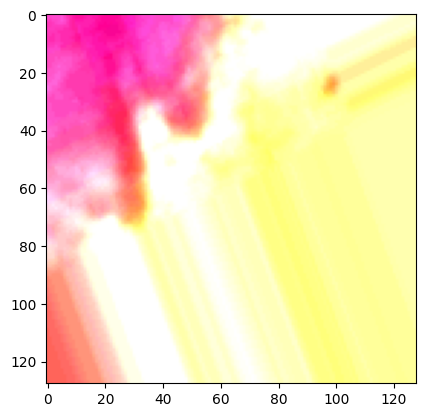

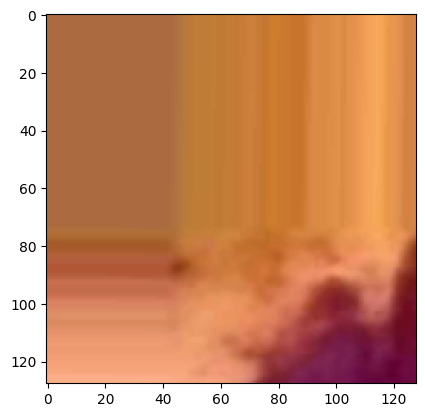

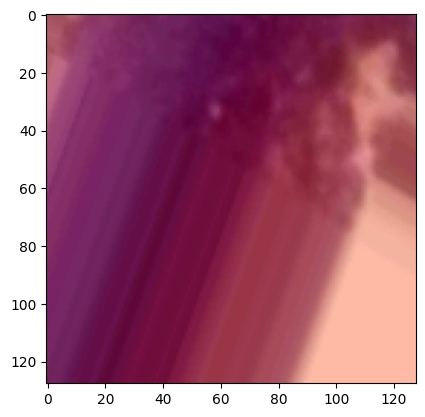

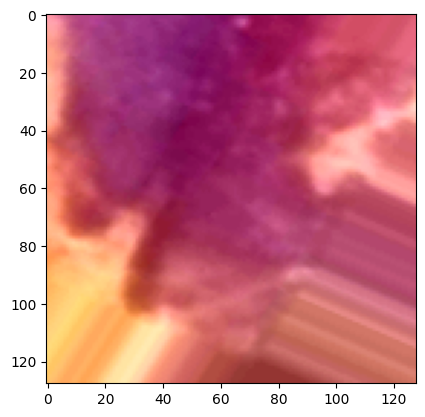

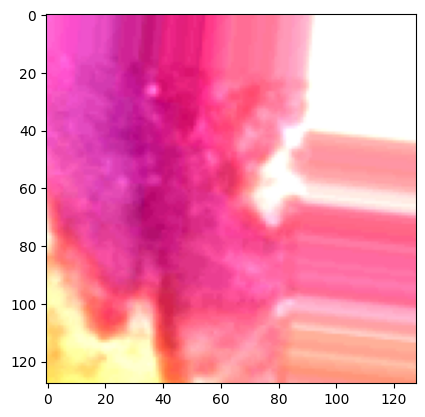

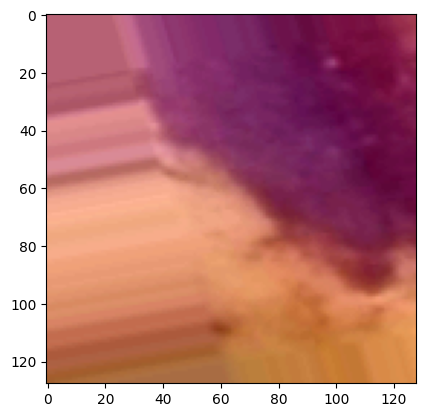

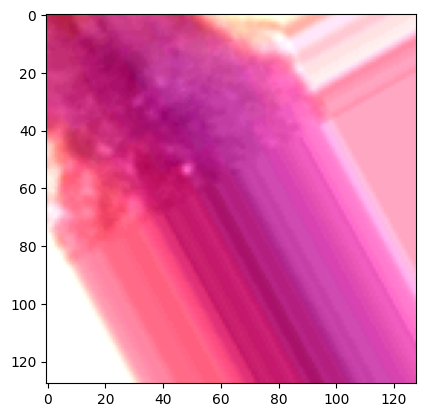

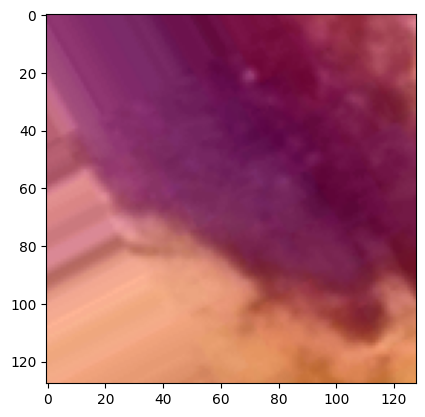

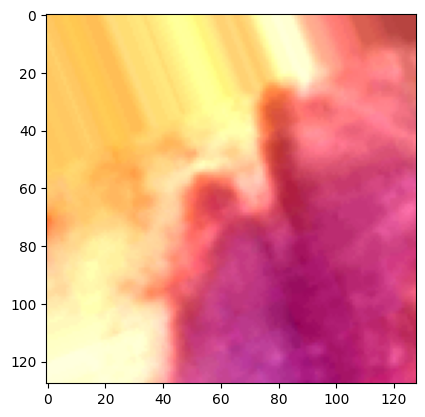

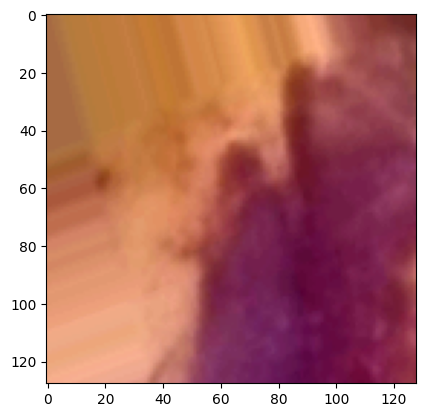

In [23]:
img = load_img("rust.jpeg")
X = img_to_array(img)
X = X.reshape((1,) + X.shape)
i = 0
for batch in trainImgGen.flow(X, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 10 == 0 :
        break
plt.show()

In [3]:
# Generamos imágenes para training cargándolas de un directorio
trainGenerator = trainImgGen.flow_from_directory(r"dataset/train",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 64 imágenes
    batch_size = 64,
    # Clasificación binaria
    class_mode = "binary"
)

# Generamos imágenes para validation cargándolas de un directorio y solamente reescalándolas
validationGenerator = testDataGen.flow_from_directory(r"dataset/validation",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 64 imágenes
    batch_size = 64,
    # Clasificación binaria
    class_mode = "binary"
)

# Generamos imágenes para testing cargándolas de un directorio y solamente reescalándolas
testGenerator = testDataGen.flow_from_directory(r"dataset/test",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 64 imágenes
    batch_size = 64,
    # Clasificación binaria
    class_mode = "binary"
)

Found 9832 images belonging to 2 classes.
Found 1529 images belonging to 2 classes.
Found 1546 images belonging to 2 classes.


## Creación de modelos

### Callbacks

In [4]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo. La extensión hdf5 es usada para guardar los pesos del modelo
    filepath = f"visionArtificial{str(datetime.date.today())}.hdf5",
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "val_accuracy",
    # Solo guardar los mejores pesos
    save_best_only = True
)

### Definición de la arquitectura

In [5]:
# Creamos un modelo secuencial
model = Sequential()

"""
Capa de entrada
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 32 kernels
        filters = 32, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
        # Datos de entrada de 128 pixeles con 3 canales
        input_shape = (128, 128, 3)
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))

"""
Capa de convolución 2
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 64 kernels
        filters = 64, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.2
model.add(Dropout(0.2))

"""
Capa de convolución 3
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.3
model.add(Dropout(0.3))

"""
Capa de convolución 4
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.4
model.add(Dropout(0.4))

"""
Capa de salida
"""
# Agregamos una capa Flatten para aplanar los datos y que queden en una sola dimensión
model.add(Flatten())
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.5
model.add(Dropout(0.5))
# Agregamos una capa Densa con 512 neuronas y activación ReLu
model.add(Dense(512, activation = "relu"))
# Agregamos la capa encargada de la clasificación binaria con activación sigmoide
model.add(Dense(1, activation = "sigmoid"))

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

### Compilación del modelo

In [6]:
model.compile(
    # Función de pérdida binary Cross Entropy
    loss = 'binary_crossentropy',
    # Como optimizador utilizamos Adam que combina las bondades de AdaGrad y RMSProp
    optimizer = optimizers.Adam(),
    # Como métrica utilizamos el Accuracy Score
    metrics = "accuracy"
)

## Entrenamiento del modelo

In [7]:
# Entrenamos el modelo con nuestro Data Generator
hist = model.fit(
    # Utiliza las imágenes generadas por el Train Generator
    trainGenerator,
    # Utilizar los callbacks que creamos
    callbacks = [checkpoint],
    # Entrenamos por 80 épocas
    epochs = 80,
    # Para validación utilizamos las imágenes generadas por el Validation Generator
    validation_data = validationGenerator,
    verbose = 2,
    # Mezclar los datos
    shuffle = True
)

Epoch 1/80

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to visionArtificial2023-09-26.hdf5
154/154 - 35s - loss: 0.0933 - accuracy: 0.9879 - val_loss: 0.0378 - val_accuracy: 1.0000 - 35s/epoch - 230ms/step
Epoch 2/80

Epoch 2: val_accuracy did not improve from 1.00000
154/154 - 27s - loss: 0.0071 - accuracy: 0.9993 - val_loss: 0.0027 - val_accuracy: 1.0000 - 27s/epoch - 176ms/step
Epoch 3/80

Epoch 3: val_accuracy did not improve from 1.00000
154/154 - 27s - loss: 0.0552 - accuracy: 0.9941 - val_loss: 0.1437 - val_accuracy: 0.9588 - 27s/epoch - 173ms/step
Epoch 4/80

Epoch 4: val_accuracy did not improve from 1.00000
154/154 - 28s - loss: 0.0283 - accuracy: 0.9950 - val_loss: 0.0052 - val_accuracy: 1.0000 - 28s/epoch - 181ms/step
Epoch 5/80

Epoch 5: val_accuracy did not improve from 1.00000
154/154 - 29s - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0029 - val_accuracy: 1.0000 - 29s/epoch - 188ms/step
Epoch 6/80

Epoch 6: val_accuracy did not improve from 1.000

## Evaluación del modelo

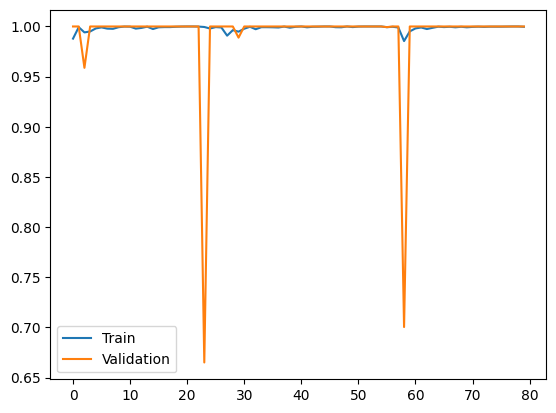

In [8]:
plt.plot(hist.history["accuracy"], label = "Train")
plt.plot(hist.history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [9]:
model.evaluate(testGenerator)

25/25 [==============================] - 1s 32ms/step - loss: 0.0047 - accuracy: 1.0000


[0.004724135622382164, 1.0]

In [3]:
postModel = load_model(r"visionArtificial2023-09-26.hdf5")

In [11]:
postModel.evaluate(testGenerator)

25/25 [==============================] - 1s 26ms/step - loss: 0.0356 - accuracy: 1.0000


[0.035635992884635925, 1.0]

1/1 [==============================] - 0s 14ms/step


[[1]]


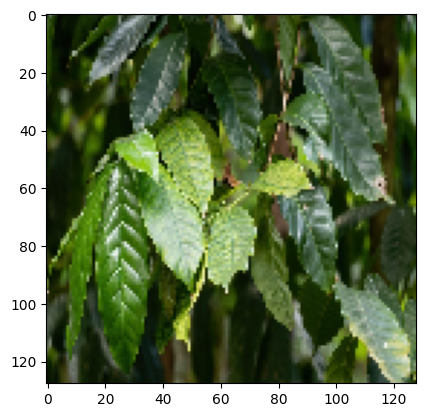

In [14]:
im = load_img('cafe.jpg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 17ms/step


[[0]]


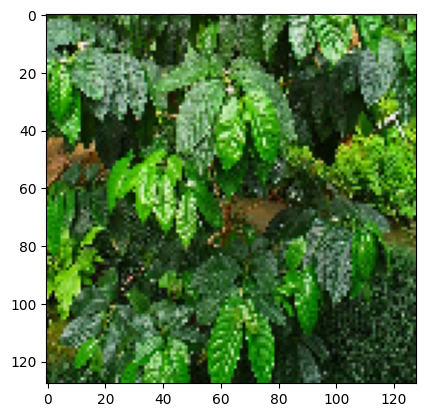

In [11]:
im = load_img('cafe2.jpg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 17ms/step


[[1]]


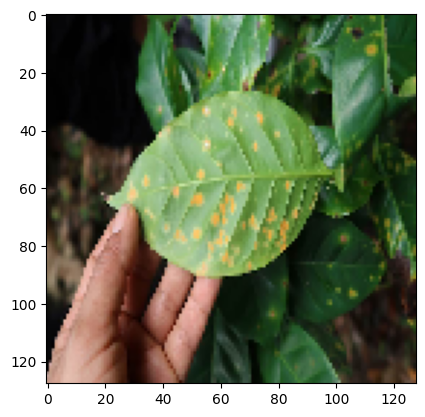

In [12]:
im = load_img('cafe3.jpg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 17ms/step


[[1]]


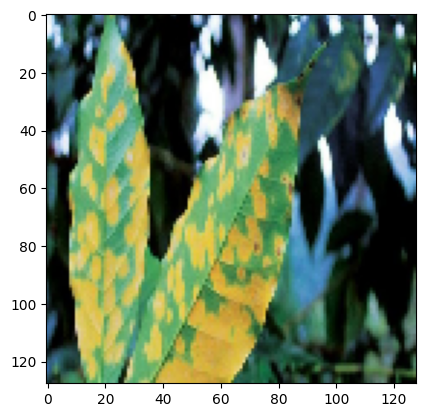

In [13]:
im = load_img('cafe4.jpeg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 15ms/step
[[0]]


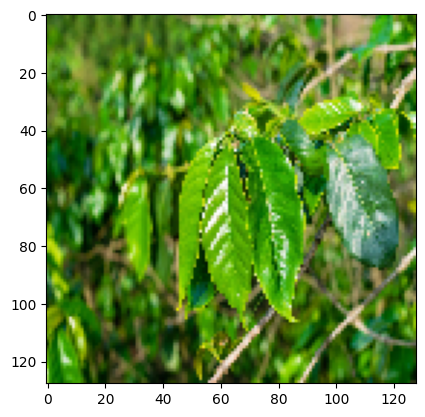

In [15]:
im = load_img('cafe5.jpg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 16ms/step
[[1]]


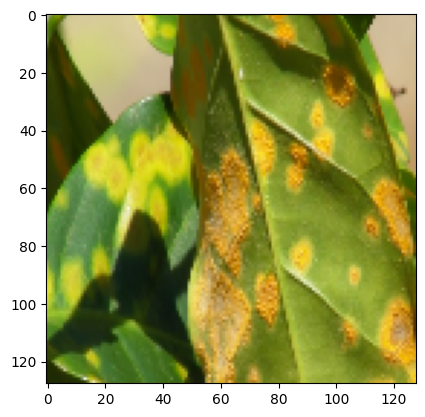

In [16]:
im = load_img('cafe6.jpg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 16ms/step
[[0]]


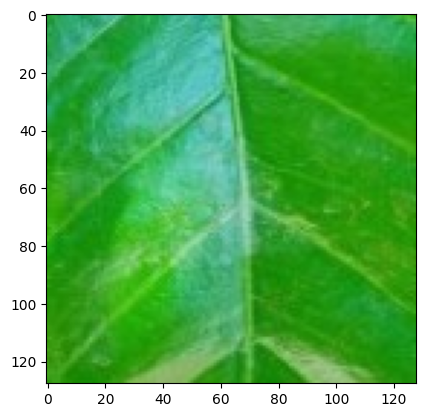

In [17]:
im = load_img('healthy.jpg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))

1/1 [==============================] - 0s 14ms/step


[[1]]


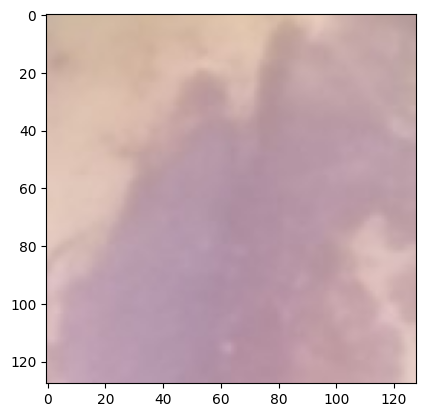

In [19]:
im = load_img('rust.jpeg', target_size=(128, 128))
imagen = img_to_array(im)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.
prediction = postModel.predict(imagen)
plt.imshow(im)
print(np.where(prediction > 0.5, 1, 0))